откроем файл

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started
!unzip \*.zip

импортируем все необходимое

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb

#metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

#tokens and co.
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

from string import punctuation

from razdel import tokenize

from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from tqdm import tqdm
import spacy

поработем с данными

In [4]:
data_train = pd.read_csv('/content/train.csv')
data_test = pd.read_csv('/content/test.csv')

In [5]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


тут я сначала решила дропнуть колонки, которые нам не нужны, потом решила еще добавить ключевое слово к тексту, чтобы был один эмбеддинг (что-то типа конкатенации, только до преобразования в вектор)

In [7]:
data_train.drop('location', axis=1, inplace=True)
data_train.drop('id', axis=1, inplace=True)
data_train.fillna('', inplace=True )
data_train['text'] = data_train['text'] + ' ' + data_train['keyword']
data_train.drop('keyword', axis=1, inplace=True)

In [8]:
data_test.drop('location', axis=1, inplace=True)
data_test.fillna('', inplace= True )
data_test['text'] = data_test['text'] + ' ' + data_test['keyword']
data_test.drop('keyword', axis=1, inplace=True)

соберем стоп слова

In [9]:
noise = stopwords.words('english') + list(punctuation)

функции для токенизации, попробуем две

In [10]:
def tokenizer(string):#razdel
    return [x.text for x in tokenize(string)]

def tokenize_text(text):#nltk
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

ОБУЧЕНИЕ

поделим на тест и трейн

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data_train.text, data_train.target, test_size=0.1)

In [12]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)#здесь хранится матрица эмбеддинг

In [ ]:
print(bow)

In [14]:
list(vec.vocabulary_.items())[:10]

[('ctaztrophe31', 4814),
 ('everything', 6506),
 ('must', 12075),
 ('be', 2643),
 ('ok', 12880),
 ('because', 2672),
 ('she', 15920),
 ('listening', 10768),
 ('to', 17747),
 ('sandstorm', 15519)]

решаем задачу классификации

In [15]:
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       468
           1       0.77      0.81      0.79       294

    accuracy                           0.83       762
   macro avg       0.82      0.83      0.83       762
weighted avg       0.84      0.83      0.83       762



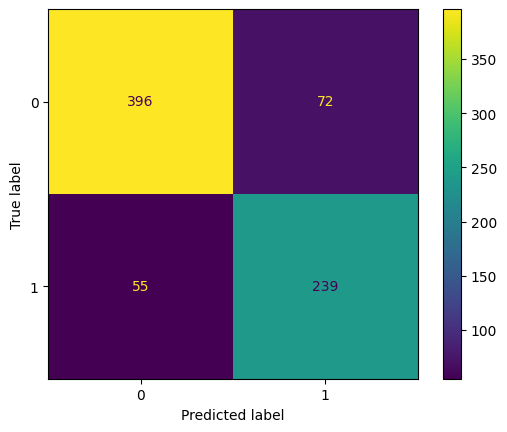

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

вроде норм

попробуем установить размер n-gram

In [17]:
vec = CountVectorizer(ngram_range=(2, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))
# стало хуже

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       533
           1       0.60      0.82      0.70       229

    accuracy                           0.78       762
   macro avg       0.76      0.80      0.76       762
weighted avg       0.82      0.78      0.79       762



стало очевидно хуже

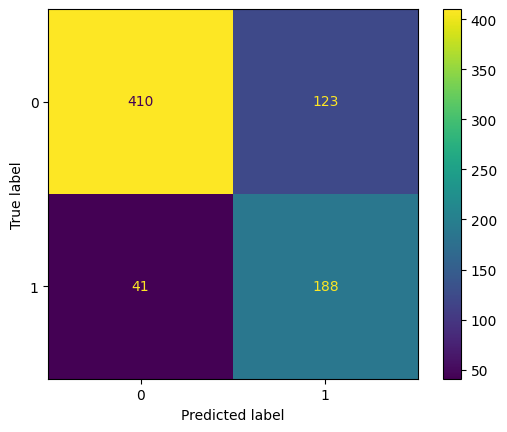

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

это с это tfidf

In [19]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(C=10, solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))
#тут стало лучше!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       449
           1       0.79      0.79      0.79       313

    accuracy                           0.83       762
   macro avg       0.82      0.82      0.82       762
weighted avg       0.83      0.83      0.83       762



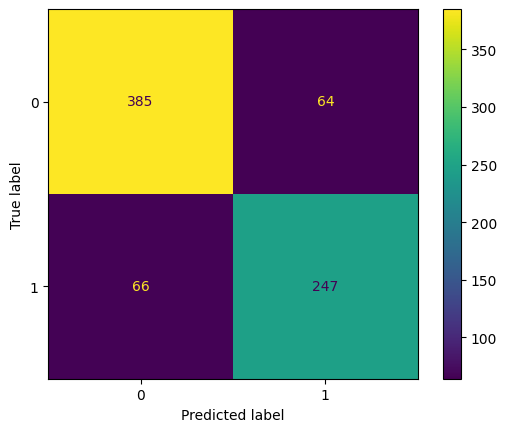

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

#пока это выглядит самым сбалансированным

применим стоп-слова и пунктуацию

In [21]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))


#еще лучше

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.83      0.84       460
           1       0.76      0.78      0.77       302

    accuracy                           0.81       762
   macro avg       0.80      0.81      0.80       762
weighted avg       0.81      0.81      0.81       762



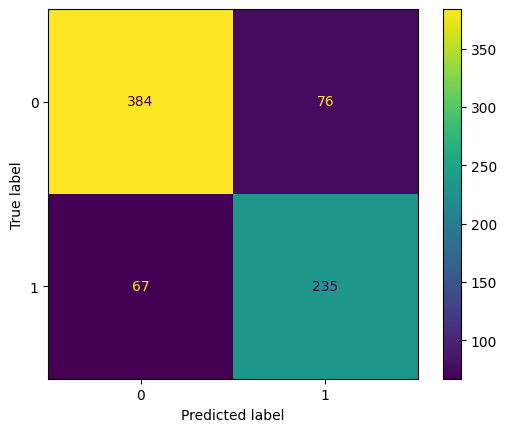

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

поменяем токенизатор на раздел

In [23]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=tokenizer, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       465
           1       0.76      0.80      0.78       297

    accuracy                           0.82       762
   macro avg       0.81      0.82      0.82       762
weighted avg       0.83      0.82      0.82       762



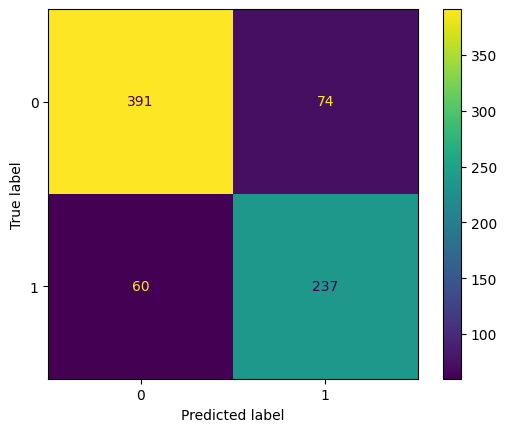

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

поменяем модель

SVC

In [25]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = SVC()
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.83      0.87       494
           1       0.73      0.84      0.78       268

    accuracy                           0.83       762
   macro avg       0.82      0.84      0.82       762
weighted avg       0.84      0.83      0.84       762



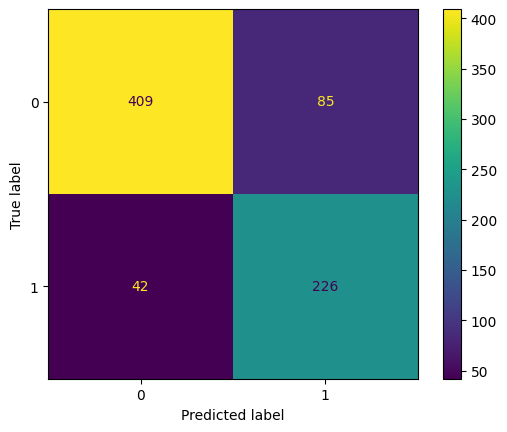

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

поменяем векторайзер

In [27]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = SVC(kernel='linear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))
#уже можно с этим работать

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.87      0.85      0.86       461
           1       0.78      0.81      0.79       301

    accuracy                           0.83       762
   macro avg       0.83      0.83      0.83       762
weighted avg       0.84      0.83      0.84       762



BaggindClassifier

In [28]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = BaggingClassifier()
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))
#  не очень

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.78      0.83       519
           1       0.63      0.80      0.70       243

    accuracy                           0.78       762
   macro avg       0.76      0.79      0.77       762
weighted avg       0.81      0.78      0.79       762



RandomForestClassifier

In [29]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      0.80      0.86       516
           1       0.67      0.85      0.75       246

    accuracy                           0.82       762
   macro avg       0.79      0.83      0.80       762
weighted avg       0.84      0.82      0.82       762



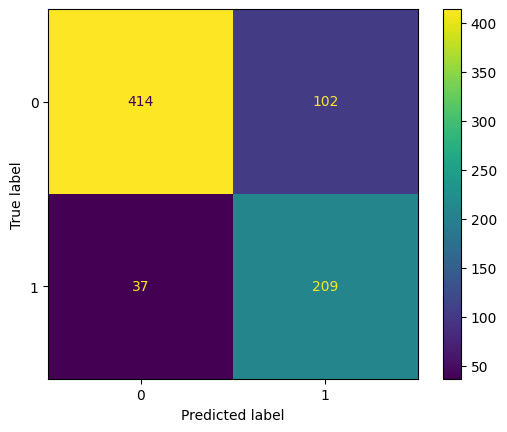

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

SGDClassifier

In [31]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = SGDClassifier(loss='log_loss')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.86      0.84      0.85       458
           1       0.77      0.79      0.78       304

    accuracy                           0.82       762
   macro avg       0.81      0.82      0.82       762
weighted avg       0.82      0.82      0.82       762



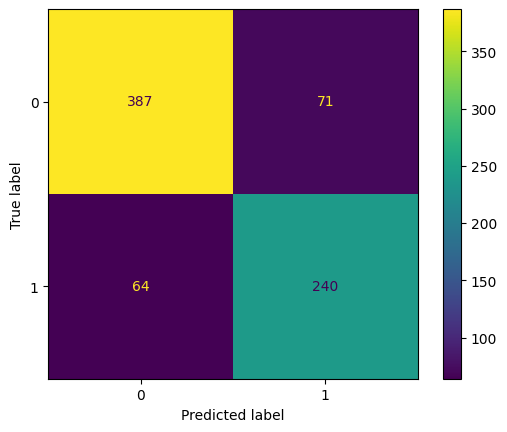

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(pred, y_test)
ConfusionMatrixDisplay(cm).plot()

XGBoost

In [33]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = xgb.XGBClassifier(random_state=0, n_jobs=1)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.77      0.83       525
           1       0.62      0.81      0.70       237

    accuracy                           0.78       762
   macro avg       0.76      0.79      0.77       762
weighted avg       0.81      0.78      0.79       762



ВАЛИДАЦИЯ

снова делим на тест и трейн, только на этот раз на настоящие

в результате прогона модели получаем ответы, которые потом кидаем в кегл на submission

In [37]:
y_test = data_test['id']
x_test = data_test['text']
y_train = data_train['target']
x_train = data_train['text']

попробуем поподбирать гиперпараметры

In [38]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(C=10, solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(pred)

[1 0 1 ... 1 1 1]


In [39]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = SVC()
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(pred)

# уже видим, что некоторые ответы различаются)

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


[1 1 1 ... 1 1 0]


возьмем модель, которая давала лучшие результаты

In [35]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer = word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))

c:\Users\пк\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


результаты сохраним в csv для загрузки на кегл

In [40]:
y_pred_test=clf.predict(vec.transform(x_test))

In [41]:
Submission = pd.DataFrame({'id' : data_test['id'],'target':y_pred_test})
Submission.to_csv('Submission7.csv',index=False)